In [2]:
import matplotlib.pyplot as plt

In [33]:
import numpy as np
import imageio
import sys
from typing import Tuple

# Some filtering functions from scipy.signal

def buttap(N):
    if abs(int(N)) != N:
        raise ValueError("Filter order must be a nonnegative integer")
    z = np.array([])
    m = np.arange(-N+1, N, 2)
    p = -np.exp(1j * np.pi * m / (2 * N))
    k = 1
    return z, p, k

def _relative_degree(z, p):
    degree = len(p) - len(z)
    if degree < 0:
        raise ValueError("Improper transfer function. "
                         "Must have at least as many poles as zeros.")
    else:
        return degree

def lp2lp_zpk(z, p, k, wo=1.0):
    z = np.atleast_1d(z)
    p = np.atleast_1d(p)
    wo = float(wo)
    degree = _relative_degree(z, p)
    z_lp = wo * z
    p_lp = wo * p
    k_lp = k * wo**degree
    return z_lp, p_lp, k_lp

def lp2bp_zpk(z, p, k, wo=1.0, bw=1.0):
    z = np.atleast_1d(z)
    p = np.atleast_1d(p)
    wo = float(wo)
    bw = float(bw)
    degree = _relative_degree(z, p)
    z_lp = z * bw/2
    p_lp = p * bw/2
    z_lp = z_lp.astype(complex)
    p_lp = p_lp.astype(complex)
    z_bp = np.concatenate((z_lp + np.sqrt(z_lp**2 - wo**2),
                           z_lp - np.sqrt(z_lp**2 - wo**2)))
    p_bp = np.concatenate((p_lp + np.sqrt(p_lp**2 - wo**2),
                           p_lp - np.sqrt(p_lp**2 - wo**2)))
    z_bp = np.append(z_bp, np.zeros(degree))
    k_bp = k * bw**degree
    return z_bp, p_bp, k_bp

def bilinear_zpk(z, p, k, fs):
    z = np.atleast_1d(z)
    p = np.atleast_1d(p)
    fs = float(fs)
    degree = _relative_degree(z, p)
    fs2 = 2.0*fs
    z_z = (fs2 + z) / (fs2 - z)
    p_z = (fs2 + p) / (fs2 - p)
    z_z = np.append(z_z, -np.ones(degree))
    k_z = k * np.real(np.prod(fs2 - z) / np.prod(fs2 - p))
    return z_z, p_z, k_z

def zpk2tf(z, p, k):
    z = np.atleast_1d(z)
    k = np.atleast_1d(k)
    if len(z.shape) > 1:
        temp = np.poly(z[0])
        b = np.empty((z.shape[0], z.shape[1] + 1), temp.dtype.char)
        if len(k) == 1:
            k = [k[0]] * z.shape[0]
        for i in range(z.shape[0]):
            b[i] = k[i] * np.poly(z[i])
    else:
        b = k * np.poly(z)
    a = np.atleast_1d(np.poly(p))
    if issubclass(b.dtype.type, np.complexfloating):
        roots = np.asarray(z, complex)
        pos_roots = np.compress(roots.imag > 0, roots)
        neg_roots = np.conjugate(np.compress(roots.imag < 0, roots))
        if len(pos_roots) == len(neg_roots):
            if np.all(np.sort_complex(neg_roots) == np.sort_complex(pos_roots)):
                b = b.real.copy()
    if issubclass(a.dtype.type, np.complexfloating):
        roots = np.asarray(p, complex)
        pos_roots = np.compress(roots.imag > 0, roots)
        neg_roots = np.conjugate(np.compress(roots.imag < 0, roots))
        if len(pos_roots) == len(neg_roots):
            if np.all(np.sort_complex(neg_roots) ==
                         np.sort_complex(pos_roots)):
                a = a.real.copy()
    return b, a

def butterworth_lowpass(N: int, Wn: float) -> Tuple[np.ndarray, np.ndarray]:
    assert np.size(Wn) == 1, "Must specify a single critical frequency Wn for lowpass or highpass filter"
    assert np.all(Wn > 0) and np.all(Wn < 1), "Digital filter critical frequencies must be 0 < Wn < 1"
    z, p, k = buttap(N)
    warped = 4 * np.tan(np.pi * Wn / 2) # digital
    z, p, k = lp2lp_zpk(z, p, k, wo=warped)
    z, p, k = bilinear_zpk(z, p, k, fs=2)
    b, a = zpk2tf(z, p, k)
    return b, a

def butterworth_bandpass(N: int, Wn: Tuple[float, float]) -> Tuple[np.ndarray, np.ndarray]:
    Wn = np.array(Wn)
    assert np.size(Wn) == 2, "Must specify a single critical frequency Wn for lowpass or highpass filter"
    assert np.all(Wn > 0) and np.all(Wn < 1), "Digital filter critical frequencies must be 0 < Wn < 1"
    z, p, k = buttap(N)
    warped = 4 * np.tan(np.pi * Wn / 2) # digital
    bw = warped[1] - warped[0]
    wo = np.sqrt(warped[0] * warped[1])
    z, p, k = lp2bp_zpk(z, p, k, wo=wo, bw=bw)
    z, p, k = bilinear_zpk(z, p, k, fs=2)
    b, a = zpk2tf(z, p, k)
    return b, a


def lfilter(b, a, x):
    a = np.array(a)
    b = np.array(b)
    y = np.zeros_like(x)
    a0 = a[0]
    if a0 != 1:
        a = a / a0
        b = b / a0
    for i in range(len(x)):
        for j in range(len(b)):
            if i - j >= 0:
                y[i] += b[j] * x[i - j]
        for j in range(1, len(a)):
            if i - j >= 0:
                y[i] -= a[j] * y[i - j]
    return y


# Other functions


def frame_binarization(frame):
    frame_gray = np.dot(frame[...,:3], [0.2989, 0.5870, 0.1140])
    threshold = 50
    frame_bin = frame_gray
    frame_bin[frame_bin < threshold] = 0
    frame_bin[frame_bin > threshold] = 1
    return frame_bin


def find_rectangle_center(bin_frame):

    # x coordinate
    vertical_lines = np.abs(np.diff(bin_frame,axis=0))
    shifted_vertical = np.roll(vertical_lines, 1, axis=1)
    v_line = vertical_lines*shifted_vertical
    v_arr = np.sum(v_line,axis=1)
    indices = np.argsort(v_arr)
    top_indices_h = indices[-4:]
    top_indices_h.sort()
    r_center_x = int((top_indices_h[1]+top_indices_h[2])/2)
    
    # y coordinate
    horizontal_lines = np.abs(np.diff(bin_frame,axis=1))
    shifted_horizontal = np.roll(horizontal_lines, 1, axis=0)
    h_line = horizontal_lines*shifted_horizontal
    h_arr = np.sum(h_line,axis=0)
    indices = np.argsort(h_arr)
    top_indices_v = indices[-4:]
    top_indices_v.sort()
    r_center_y = int((top_indices_v[1]+top_indices_v[2])/2)

    rectangle_egdes = (top_indices_h,top_indices_v)

    return (r_center_x, r_center_y, rectangle_egdes)


def bin_image_labeling(img_bin):
    (height, width) = img_bin.shape
    bw_img = np.zeros((height, width), dtype=int)
    label = 0
    for x in range(0,height):
        for y in range(0,width):
            if (img_bin[x, y] == 1) and (bw_img[x,y] == 0):
                label += 1
                bw_img[x,y] = label
                if (y!=width-1) and (img_bin[x,y+1] == 1):
                    bw_img[x,y+1] = label
                if (x!=height-1) and (y!=0) and (img_bin[x+1,y-1] == 1):
                    bw_img[x+1,y-1] = label
                if (x!=height-1) and (img_bin[x+1,y] == 1):
                    bw_img[x+1,y] = label
                if (x!=height-1) and (y!=width-1) and (img_bin[x+1,y+1] == 1):
                    bw_img[x+1,y+1] = label
    if label > 1:
        for x in range(2,height-3):
            for y in range(2,width-3):
                if bw_img[x,y] != 0:
                    mask = bw_img[x-2:x+3,y-2:y+3]
                    mask[mask>0] = np.min(mask[mask>0])
                    bw_img[x-2:x+3,y-2:y+3] = mask
    vals = np.unique(bw_img)
    for i in range(len(vals)):
        bw_img[bw_img == vals[i]] = i
    return bw_img


def find_leftmost_circle_center(img_without_rec,rectangle_edges):

    (x_edges,y_edges) = rectangle_edges
    img_without_rec = bin_first_frame
    img_without_rec[x_edges[0]:x_edges[3]+1,y_edges[0]:y_edges[3]+1]=0

    bw_img = bin_image_labeling(img_without_rec)
    vals = np.unique(bw_img)   
    left_ind = float('inf')
    for val in vals:
        if val != 0:
            circle = np.zeros_like(img_without_rec)
            circle[bw_img==val]=1
            
            vertical_edges = np.abs(np.diff(circle,axis=0))
            y_arr = np.sum(vertical_edges,axis=1)
            x_ind_1 = np.nonzero(y_arr)[0][0]
            x_ind_2 = np.nonzero(y_arr)[0][-1]

            horizontal_edges = np.abs(np.diff(circle,axis=1))
            y_arr = np.sum(horizontal_edges,axis=0)
            y_ind_1 = np.nonzero(y_arr)[0][0]
            y_ind_2 = np.nonzero(y_arr)[0][-1]

            if y_ind_1 < left_ind:
                left_ind = y_ind_1
                x_center = int((x_ind_1+x_ind_2)/2)
                y_center = int((y_ind_1+y_ind_2)/2) + 1


    return (x_center,y_center)


def find_peaks(data, min_distance=1):
    peaks = []
    last_peak_index = 0
    for i in range(1, len(data) - 1):
        if data[i] > data[i - 1] and data[i] > data[i + 1]:
            if i - last_peak_index >= min_distance:
                peaks.append(i)
                last_peak_index = i
    return peaks


def multiple_bounces(bounce):
    flag = False
    
    arr = np.sum(bounce,axis=0)
    arr[arr>1]=1
    start_indices = np.where(np.logical_and(arr[:-2] == 1, np.logical_and(arr[1:-1] == 0, arr[2:] == 1)))[0]
    for idx in start_indices:
        arr[idx + 1] = 1
    diffs = np.abs(np.diff(arr))
    if np.sum(diffs) > 3:
        flag = True
    else:
        arr = np.sum(bounce,axis=1)
        arr[arr>1]=1
        start_indices = np.where(np.logical_and(arr[:-2] == 1, np.logical_and(arr[1:-1] == 0, arr[2:] == 1)))[0]
        for idx in start_indices:
            arr[idx + 1] = 1
        diffs = np.abs(np.diff(arr))
        if np.sum(diffs) > 3:
            flag = True
    
    return flag


def find_video_bounces(video_frames,bin_first_frame,rectangle_edges):

    (x_edges,y_edges) = rectangle_edges
    (height,width) = bin_first_frame.shape

    rectangle_mask = np.zeros_like(bin_first_frame)
    rectangle_mask[x_edges[0]:x_edges[3]+2,y_edges[0]:y_edges[3]+3] = 1

    edges_mask = np.zeros_like(bin_first_frame)
    rectangle_width = 2
    edge_width = 3
    edges_mask[x_edges[0]+1-rectangle_width:x_edges[3]+1+rectangle_width,y_edges[0]-rectangle_width:y_edges[3]+2+rectangle_width]=1
    edges_mask[0:edge_width,:] = 1
    edges_mask[height-edge_width:height,:] = 1
    edges_mask[:,0:edge_width] = 1
    edges_mask[:,width-edge_width:width] = 1
    
    bounces = []
    last_bounce = np.zeros_like(edges_mask)
    
    flag = True
    for i in range(len(video_frames)):

        bin_frame = frame_binarization(video_frames[i])
        frame_without_rec = bin_frame - rectangle_mask
        frame_without_rec[frame_without_rec < 0] = 0
        
        bounce = frame_without_rec*edges_mask

        if np.any(bounce):
            
            if not np.any(bounce*last_bounce):
                bounces.append(i)
                """plt.figure(figsize = (15,10))
                plt.imshow(video_frames[i],cmap='gray'); plt.title(round(i/30,3))
                plt.imshow(bounce,alpha=0.9)"""

            elif flag:
                if multiple_bounces(bounce):
                    bounces.append(i)
                    flag = False
                    """plt.figure(figsize = (15,10))
                    plt.imshow(bounce,alpha=0.9,cmap='gray'); plt.title(round(i/30,3))"""
            
        else:
            flag = True
        last_bounce = bounce
        
    return bounces


def audio_video_sync(t_peaks,t_bounces,FPS):

    N_bounces = len(t_bounces)
    N_peaks = len(t_peaks)
    best_match = float('inf')
    
    if N_bounces == N_peaks:
        t_start_frame = np.mean([t_bounces[i]-t_peaks[i] for i in range(N_bounces)])
    else:
        for i1 in range(N_bounces-1):
            for i2 in range(N_peaks-1):
                # poravnala sam i1 bounce sa i2 pikom
                # ovo ce da bude dobro ako se jos neki par pikova dovoljno poklapa
                t = t_bounces[i1]-t_peaks[i2]
                if (t < 0):
                    continue
                else:
                    matches = np.zeros((N_bounces-i1-1,N_peaks-i2-1))
                    for j in range(i1+1,N_bounces):
                        for k in range(i2+1,N_peaks):    
                            matches[j-i1-1,k-i2-1] = np.abs(t_bounces[j]-t_peaks[k]-t)

                    best_match_ind = np.unravel_index(np.argmin(matches), matches.shape)
                    best_match_tmp = matches[best_match_ind]

                    if (best_match_tmp < best_match) and (t_bounces[i1+1+best_match_ind[0]] > t_peaks[i2+1+best_match_ind[1]]):
                        t_start_frame = t
                        best_match = best_match_tmp

    N_start_frame = int(t_start_frame*FPS)
    return N_start_frame

# --- main ---

for i in range(10):

    #i = 0
    audio_path = 'public2\set\{}\sound.npy'.format(i)
    video_path = r'public2\set\{}\video.mp4'.format(i)
    #video_path = input()
    #audio_path = input()

    # video processing
    FPS = 30
    video = imageio.get_reader(video_path, 'ffmpeg')
    video_frames = []
    for image in video:
        video_frames.append(np.array(image))
    video = np.array(video_frames)

    bin_first_frame = frame_binarization(video[0,:,:,:])
    (r_center_x, r_center_y, rectangle_edges) = find_rectangle_center(bin_first_frame)

    (x_center,y_center) = find_leftmost_circle_center(bin_first_frame,rectangle_edges)

    bounces = find_video_bounces(video_frames,bin_first_frame,rectangle_edges)
    N_bounces = len(bounces)
    t_bounces = [bounce/FPS for bounce in bounces]

    # audio processing
    fs = 44100
    audio = np.load(audio_path)

    (b,a) = butterworth_lowpass(5, 2*np.pi*32/fs)
    audio = lfilter(b,a,audio)
    audio[audio < 0.3*max(audio)] = 0
    peaks = find_peaks(audio)
    N_peaks = len(peaks)
    t_peaks = [peak/fs for peak in peaks]

    # audio video sync
    N_start_frame = audio_video_sync(t_peaks,t_bounces,FPS)

    # output
    print(x_center,y_center)
    print(r_center_x,r_center_y)
    print(N_peaks)
    print(N_bounces)
    print(N_start_frame)
    print('')


22 26
72 89
5
5
2

252 135
107 314
5
4
4

50 83
224 235
8
7
64

98 94
148 294
11
14
56

187 49
225 365
8
9
45

157 33
92 292
17
20
32

43 75
75 186
10
10
2

99 52
41 112
20
10
28

45 79
253 392
19
13
35

58 57
210 421
6
13
73



In [150]:
"""import sounddevice as sd

audio = np.load(audio_path)
sd.play(audio,fs)
sd.wait()"""

t_start = 4/FPS
print([np.round(t_start+t_peak,3) for t_peak in t_peaks])
print(np.round(t_bounces,3))

[0.219, 0.535, 2.619, 3.202, 3.735]
[0.2   0.533 2.6   3.167 3.733]


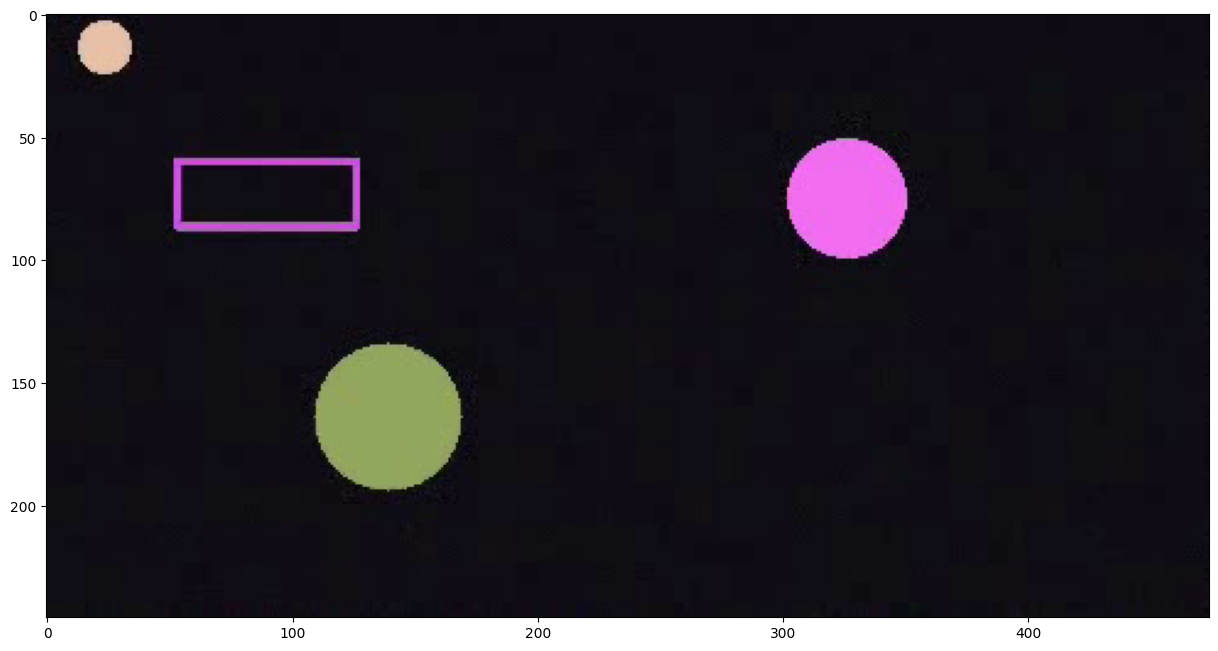

In [140]:
frame_ind = int(0.4330*30)

plt.figure(figsize=(15,10))
plt.imshow(video_frames[frame_ind])